# arXiv:2311.06199

# Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.linalg import eigh
from scipy.sparse import csr_matrix, save_npz, load_npz, kron, identity
from scipy.integrate import solve_ivp
from scipy.sparse.linalg import expm
# matplotlib parameters 
large = 40; med = 25; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': small,
          'axes.labelsize': med ,
          'axes.titlesize': small ,
          'xtick.labelsize': small ,
          'ytick.labelsize': small ,
          'figure.titlesize': med}
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.serif"] = ["Helvetica Neue"]     
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Computer Modern Roman']     
#plt.rcParams['text.usetex'] = True # need LaTeX. Change it to False if LaTeX is not installed in the system
plt.rcParams.update(params)

In [21]:
# Define character sets
lowercase = 'abcdefghijklmnopqrstuvwxyz'
uppercase = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
digits = '0123456789'
special = '@#$%&'

# Combine all characters
all_chars = lowercase + uppercase + digits + special

# Generate password of length 29
password = ''.join(np.random.choice(list(all_chars), size=19))
print(f"Generated password: {password}")

Generated password: Fib03hBSQCIjYARe3s6


In [11]:
# Constants
n = 4  # Number of qubits
J_total = 1
Delta = 0.5
gamma = 0.5
gamma_e = gamma
gamma_d = gamma

# Lindblad equation

In [12]:
# Pauli matrices and identity (sparse format)
I2 = csr_matrix([[1, 0], [0, 1]], dtype=complex)
sigma_x = csr_matrix([[0, 1], [1, 0]], dtype=complex)
sigma_y = csr_matrix([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = csr_matrix([[1, 0], [0, -1]], dtype=complex)

def build_hamiltonian(n):
    """Construct the Hamiltonian for the infinite-ranged Ising model."""
    H = csr_matrix((2**n, 2**n), dtype=complex)

    J_0 = J_total / (n-1)
    # Infinite ranged XX term
    for i in range(n-1):
        for j in range(i+1, n):
            X_ops = [I2] * n
            X_ops[i] = sigma_x
            X_ops[j] = sigma_x
            X_term = X_ops[0]
            for op in X_ops[1:]:
                X_term = kron(X_term, op)

            H += J_0 * X_term

    # Z field term
    for i in range(n):
        Z_ops = [I2] * n
        Z_ops[i] = sigma_z
        Z_term = Z_ops[0]
        for op in Z_ops[1:]:
            Z_term = kron(Z_term, op)

        H -= Delta * Z_term

    return H

lindblad_op_sigma_plus_lst = []
lindblad_op_sigma_minus_lst = []
lindblad_op_sigma_z_lst = []

for i in range(n):
    # sigma+ operator
    sigma_plus_i = [I2] * n
    sigma_plus_i[i] = (sigma_x + 1j*sigma_y) / 2
    sigma_plus_i_op = sigma_plus_i[0]
    for op in sigma_plus_i[1:]:
        sigma_plus_i_op = kron(sigma_plus_i_op, op)

    # sigma+ operator
    lindblad_op_sigma_plus_lst.append(sigma_plus_i_op)

    # sigma- operator
    sigma_minus_i_op = sigma_plus_i_op.conj().T
    lindblad_op_sigma_minus_lst.append(sigma_minus_i_op)

    # sigma_z operator
    sigma_z_i = [I2] * n
    sigma_z_i[i] = sigma_z
    sigma_z_i_op = sigma_z_i[0]
    for op in sigma_z_i[1:]:
        sigma_z_i_op = kron(sigma_z_i_op, op)

    lindblad_op_sigma_z_lst.append(sigma_z_i_op)


def build_liouvillian(n):
    """Construct the Liouvillian superoperator."""
    H = build_hamiltonian(n)
    d = H.shape[0]
    I = identity(d, format="csr")
    
    # Hamiltonian contribution
    H_comm = -1j * (kron(I, H) - kron(H.conj().T, I))

    # Lindblad contributions
    lindblad_diss_term = csr_matrix((H_comm.shape[0], H_comm.shape[0]), dtype=complex)

    for i in range(n):

        sigma_plus_i_op = lindblad_op_sigma_plus_lst[i]
        sigma_minus_i_op = lindblad_op_sigma_minus_lst[i]
        sigma_z_i_op = lindblad_op_sigma_z_lst[i]  

        # The mapping of each term is explained in Overleaf.       
        lindblad_diss_term += gamma_e/2 * (kron(I, sigma_plus_i_op @ sigma_minus_i_op)
                             + kron((sigma_plus_i_op @ sigma_minus_i_op).T, I)
                             - 2 * kron(sigma_plus_i_op.T, sigma_minus_i_op))
        lindblad_diss_term += gamma_d/4 * (kron(I, I) - kron(sigma_z_i_op.T, sigma_z_i_op))


    return H_comm - lindblad_diss_term

"""
def build_liouvillian(n):
    H = build_hamiltonian(n)
    d = H.shape[0]
    I = identity(d, format="csr")
    
    # Hamiltonian contribution
    H_comm = -1j * (kron(I, H) - kron(H.conj().T, I))

    # Lindblad contributions
    lindblad_diss_term = csr_matrix((H_comm.shape[0], H_comm.shape[0]), dtype=complex)

    for i in range(n):
        # Emission (sigma_minus) operator
        L_1_i = [I2] * n
        L_1_i[i] = (sigma_x - 1j * sigma_y) / 2
        L_1_i_op = L_1_i[0]
        for op in L_1_i[1:]:
            L_1_i_op = kron(L_1_i_op, op)

        # Dephasing (I + sigma_z) operator
        L_2_i = [I2] * n
        L_2_i[i] = (I2 + sigma_z) / 2
        L_2_i_op = L_2_i[0]
        for op in L_2_i[1:]:
            L_2_i_op = kron(L_2_i_op, op)

        # Jump operators
        L_1 = np.sqrt(gamma_e) * L_1_i_op
        L_2 = np.sqrt(gamma_d) * L_2_i_op

        lindblad_diss_term += kron(L_1.conj(), L_1) - 0.5 * (kron(I, L_1.getH() @ L_1) + kron((L_1.getH() @ L_1).T, I))
        lindblad_diss_term += kron(L_2.conj(), L_2) - 0.5 * (kron(I, L_2.getH() @ L_2) + kron((L_2.getH() @ L_2).T, I))

    return H_comm + lindblad_diss_term
"""

def cost_function(rho, L_vec):
    """Compute the cost function Tr[(L(rho))^2]."""
    rho_vec = rho.flatten(order="F")  # Vectorize rho
    L_rho_vec = L_vec @ rho_vec  # Apply Liouvillian
    return np.linalg.norm(L_rho_vec)**2  # Compute squared norm

def lindblad_time_evolution_with_cost(n, rho_0, t_max, dt):
    """Simulate Lindblad equation and compute cost function at each step."""
    d = 2**n
    L_vec = build_liouvillian(n)
    rho_vec = rho_0.flatten(order="F")  # Vectorize initial state

    # Time evolution using matrix exponential
    exp_Lt = expm(L_vec * dt)

    times = np.arange(0, t_max, dt)
    results = []
    costs = []

    for t in times:
        # Compute cost function
        rho = rho_vec.reshape((d, d), order="F")  # Reshape back to density matrix
        cost = cost_function(rho, L_vec)
        costs.append(cost)
        
        rho_vec = exp_Lt @ rho_vec  # Update density matrix
        rho_vec = rho_vec / np.trace(rho_vec.reshape((d, d), order="F"))  # Normalize

        results.append(rho_vec.reshape((d, d), order="F"))

    return times, results, costs

# Steady state simulation

In [13]:
t_max = 10
dt = 0.01

# Helper function to construct the tensor product of single-qubit states
def build_initial_state(n):
    """Construct the initial state |0><0| for n qubits."""
    # Single-qubit |0><0| state
    rho_single = csr_matrix([[1, 0], [0, 0]], dtype=complex)

    # Tensor product to extend to n qubits
    rho_0 = rho_single
    for _ in range(n - 1):
        rho_0 = kron(rho_0, rho_single)
    # Normalize
    rho_0 = rho_0 / np.trace(rho_0.toarray())
    return rho_0.toarray()  # Convert to dense array if needed

rho_0 = build_initial_state(n) # Initial state
# Run simulation with cost function
times, results, costs = lindblad_time_evolution_with_cost(n, rho_0, t_max, dt)

#populations = [np.real(rho[0, 0]) for rho in results]

In [14]:
def FM_order(rho):
    # Initialize the spin correlation matrix
    spin_matrix = csr_matrix((rho.shape[0], rho.shape[0]), dtype=complex)
    
    for i in range(n):
        for j in range(n):
            # Create sigma_x operator for qubit i
            sigma_x_ij = [I2] * n
            sigma_x_ij[i] = sigma_x            
            # Create sigma_x operator for qubit j
            sigma_x_ij[j] = sigma_x
            sigma_x_ij_op = sigma_x_ij[0]
            for op in sigma_x_ij[1:]:
                sigma_x_ij_op = kron(sigma_x_ij_op, op)
                
            spin_matrix += sigma_x_ij_op

    # Calculate M_F using the trace formula
    mf = np.trace(spin_matrix.toarray() @ rho) / n**2
    return mf.real  # Return the real part (expectation values are real)

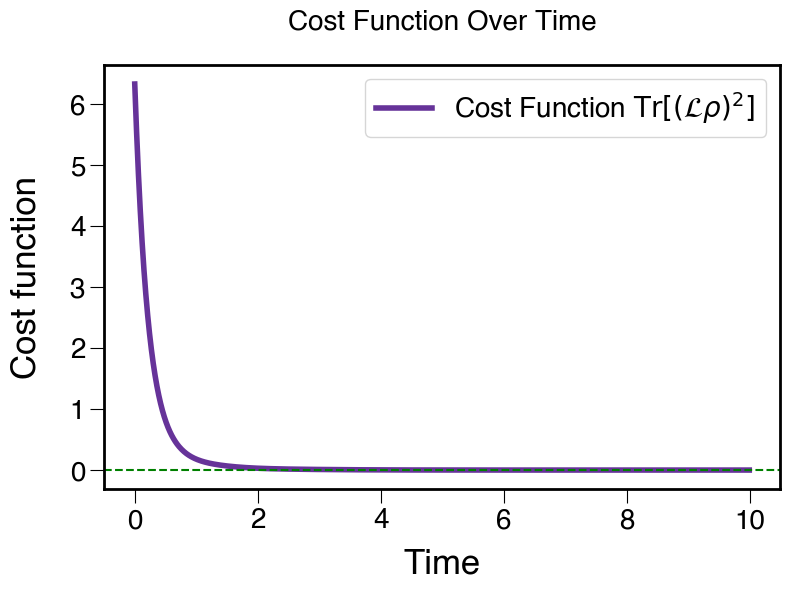

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(times, costs, label=r"Cost Function $\text{Tr}[(\mathcal{L}\rho)^2]$", color="rebeccapurple", lw=4)
plt.legend()
plt.xlabel("Time", labelpad=10)
plt.ylabel("Cost function", labelpad=20)
#plt.yscale("log")  # Optional: Log scale for better visualization
plt.title("Cost Function Over Time")
plt.axhline(0, color="green", linestyle="--")
ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', length=10)
plt.tight_layout()
#plt.savefig("XXZ_n_"+str(n)+ "_Delta_"+ str(Delta)+ "_g_1_"+ str(gamma_1)+ "_g_2_"+ str(gamma_2)+".png", dpi=600, bbox_inches="tight")
plt.show()

In [16]:
rho_steady_state = results[-1]
# Convert the dense array to CSR sparse matrix
rho_steady_state_sparse = csr_matrix(rho_steady_state)
# Save the steady state density matrix in sparse format
#save_npz("Ising_infinite_ranged_n_"+str(n)+ "_Delta_"+ str(Delta)+ "_gamma_"+ str(gamma)+".npz", rho_steady_state_sparse)

print(r"\Delta = ", Delta, r" \gamma = ", gamma, "FM order = ", FM_order(rho_steady_state_sparse.toarray()))

\Delta =  0.5  \gamma =  0.5 FM order =  0.191849009438975


In [17]:
# # # Load the two density matrices.
# rho_1 = load_npz("Ising_infinite_ranged_n_6_Delta_0.5_gamma_0.1.npz")
# rho_2 = load_npz("Ising_infinite_ranged_n_6_Delta_1.5_gamma_0.9.npz")

In [18]:
# FM_order_1 = FM_order(rho_1.toarray())
# FM_order_2 = FM_order(rho_2.toarray())

# print("FM order parameter for Delta = 0.5, gamma = 0.15: ", FM_order_1)
# print("FM order parameter for Delta = 1.3, gamma = 1.2: ", FM_order_2)